# Import Libraries

In [55]:
import numpy as np
import cv2
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
import random

# Import different classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [56]:
# parameters for display

%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

In [57]:
#PATH
kaggle_dataset_path = "fruit_datasets/kaggle_data"
zenodo_fruitQ_DB_dataset_path = "fruit_datasets/zenodo_data"

# Interface Declarations

## Data Loading Logic

In [58]:
class FruitQualityDataLoader:
    def __init__(self):
        self.quality_mappings = {
            'fresh': 0, 'good': 0,
            'mild': 1, 'mixed': 1,
            'rotten': 2, 'bad': 2
        }
        self.quality_labels = ['Good/Fresh', 'Mild/Mixed', 'Rotten/Bad']
        
    def load_zenodo_dataset(self, base_path, subset="FruQ-DB"):
        """Load Zenodo dataset"""
        base_path = Path(base_path)
        image_paths = []
        labels = []
        
        if subset == "FruQ-DB":
            dataset_path = base_path / "FruQ-DB"
            if not dataset_path.exists():
                raise ValueError(f"FruQ-DB not found at {dataset_path}")
            
            # Process quality folders directly
            quality_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
            
            for folder in quality_folders:
                if folder.name.lower() in self.quality_mappings:
                    label = self.quality_mappings[folder.name.lower()]
                    print(f"Processing {folder.name}...")
                    
                    for img_path in folder.glob('*.[jp][pn][g]'):
                        image_paths.append(str(img_path))
                        labels.append(label)
        
        elif subset == "FruQ-multi":
            dataset_path = base_path / "FruQ-multi"
            fruit_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
            
            for fruit_folder in fruit_folders:
                print(f"Processing fruit: {fruit_folder.name}")
                quality_folders = [f for f in fruit_folder.iterdir() if f.is_dir()]
                
                for folder in quality_folders:
                    if folder.name.lower() in self.quality_mappings:
                        label = self.quality_mappings[folder.name.lower()]
                        print(f"Processing quality: {folder.name}...")
                        
                        for img_path in folder.glob('*.[jp][pn][g]'):
                            image_paths.append(str(img_path))
                            labels.append(label)
                            
        return self._summarize_and_return(image_paths, labels)

    def load_kaggle_dataset(self, base_path):
        """
        Load Kaggle dataset with the following structure:
        - Bad Quality_Fruits/
            - Apple_Bad/
            - Banana_Bad/
            etc.
        - Good Quality_Fruits/
            - Apple_Good/
            - Banana_Good/
            etc.
        - Mixed Quality_Fruits/
            - Apple/
            - Banana/
            etc.
        """
        base_path = Path(base_path)
        image_paths = []
        labels = []
        
        # Define quality directories and their corresponding labels
        quality_dirs = {
            'Bad Quality_Fruits': 2,    # maps to 'bad'/'rotten'
            'Good Quality_Fruits': 0,   # maps to 'good'/'fresh'
            'Mixed Qualit_Fruits': 1    # maps to 'mixed'/'mild'
        }
        
        # Process each quality directory
        for quality_dir, label in quality_dirs.items():
            quality_path = base_path / quality_dir
            if not quality_path.exists():
                print(f"Warning: {quality_dir} not found at {quality_path}")
                continue
                
            print(f"\nProcessing {quality_dir}...")
            
            # Get all fruit subdirectories
            fruit_dirs = [f for f in quality_path.iterdir() if f.is_dir()]
            
            # Process each fruit directory
            for fruit_dir in fruit_dirs:
                print(f"Processing {fruit_dir.name}...")
                
                # Handle both .jpg and .png files
                for img_path in fruit_dir.glob('*.[jp][pn][g]'):
                    image_paths.append(str(img_path))
                    labels.append(label)
        
        return self._summarize_and_return(image_paths, labels)
    
    def _summarize_and_return(self, image_paths, labels):
        """Helper method to summarize dataset statistics and return results"""
        print(f"\nDataset Statistics:")
        unique, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return image_paths, np.array(labels)
    
    def load_combined_datasets(self, kaggle_path, zenodo_path, zenodo_subset="FruQ-DB"):
        """
        Load and combine both Kaggle and Zenodo datasets
        """
        # Load Kaggle dataset
        kaggle_paths, kaggle_labels = self.load_kaggle_dataset(kaggle_path)
        
        # Load Zenodo dataset
        zenodo_paths, zenodo_labels = self.load_zenodo_dataset(zenodo_path, zenodo_subset)
        
        # Combine datasets
        combined_paths = kaggle_paths + zenodo_paths
        combined_labels = np.concatenate([kaggle_labels, zenodo_labels])
        
        print("\nCombined Dataset Statistics:")
        unique, counts = np.unique(combined_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return combined_paths, combined_labels
    
    def sample_dataset(self, image_paths, labels, percentage=10, seed=None):
        """
        Extract a random percentage of the dataset.
        - image_paths: List of image paths.
        - labels: List of corresponding labels.
        - percentage: Percentage of the dataset to extract (default: 10%).
        - seed: Seed for reproducibility (default: None).
        Returns:
            A subset of image_paths and labels.
        """
        if seed is not None:
            random.seed(seed)
        
        # Calculate the number of samples to extract
        total_samples = len(image_paths)
        sample_size = int((percentage / 100) * total_samples)
        
        # Generate random indices
        sampled_indices = random.sample(range(total_samples), sample_size)
        
        # Extract sampled paths and labels
        sampled_paths = [image_paths[i] for i in sampled_indices]
        sampled_labels = [labels[i] for i in sampled_indices]
        
        print(f"Sampled {sample_size}/{total_samples} ({percentage}%) images.")
        
        return sampled_paths, sampled_labels

Data Set Visualization 


Processing Zenodo Dataset...
Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images


/tmp/ipykernel_84068/4179079898.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[quality_labels[label] for label in unique_labels], y=counts, palette="viridis")


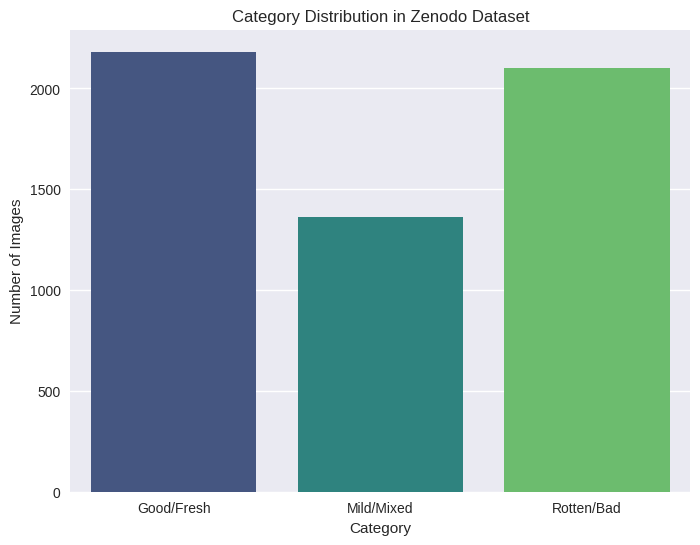

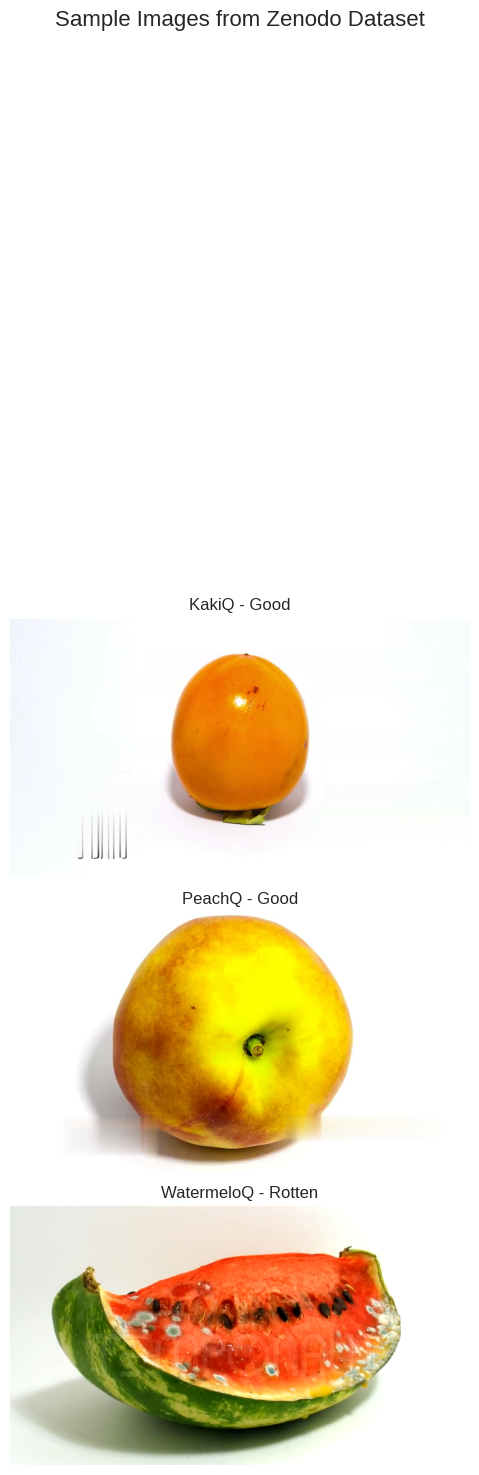


Processing Kaggle Dataset...

Processing Bad Quality_Fruits...
Processing Apple_Bad...
Processing Banana_Bad...
Processing Guava_Bad...
Processing Lime_Bad...
Processing Orange_Bad...
Processing Pomegranate_Bad...

Processing Good Quality_Fruits...
Processing Apple_Good...
Processing Banana_Good...
Processing Guava_Good...
Processing Lime_Good...
Processing Orange_Good...
Processing Pomegranate_Good...

Processing Mixed Qualit_Fruits...
Processing Apple...
Processing Banana...
Processing Guava...
Processing Lemon...
Processing Orange...
Processing Pomegranate...

Dataset Statistics:
Good/Fresh: 9170 images
Mild/Mixed: 1074 images
Rotten/Bad: 5575 images


/tmp/ipykernel_84068/4179079898.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[quality_labels[label] for label in unique_labels], y=counts, palette="viridis")


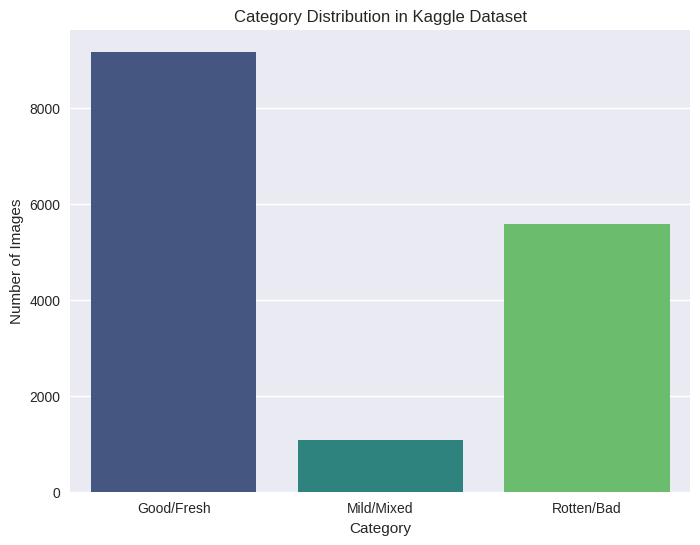

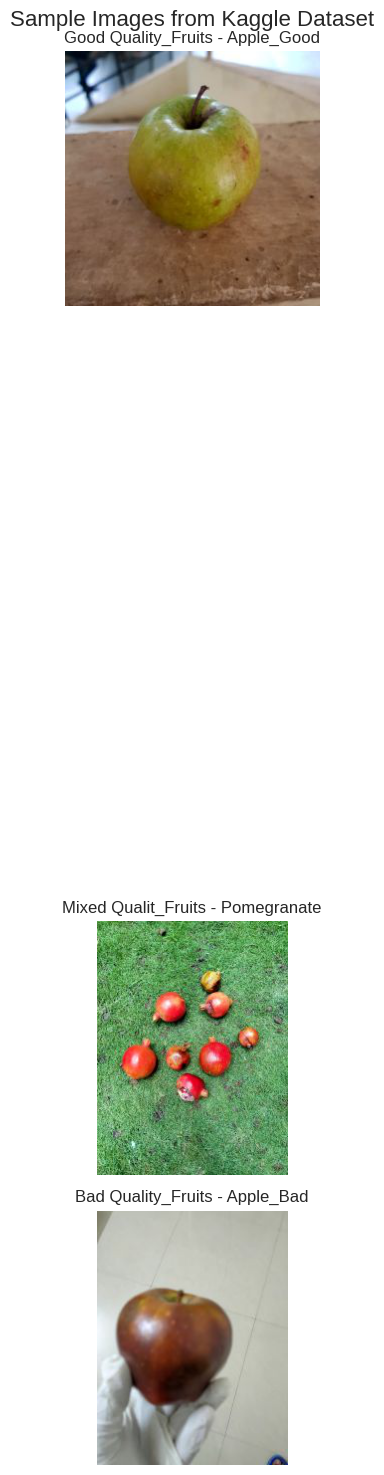

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import random
import cv2

def visualize_distribution(labels, quality_labels, dataset_name):
    """Visualize category distribution."""
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=[quality_labels[label] for label in unique_labels], y=counts, palette="viridis")
    plt.title(f"Category Distribution in {dataset_name} Dataset")
    plt.ylabel("Number of Images")
    plt.xlabel("Category")
    plt.show()

def display_sample_images(subfolders, num_to_display=5, dataset_name="Dataset"):
    """Display sample images from the dataset."""
    sampled_subfolders = random.sample(subfolders, min(len(subfolders), num_to_display))
    plt.figure(figsize=(15, len(sampled_subfolders) * 3))
    for i, subfolder in enumerate(sampled_subfolders):
        img_path = next(subfolder.glob("*.[jp][pn][g]"), None)
        if img_path:
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label = subfolder.parent.name + " - " + subfolder.name
            plt.subplot(len(sampled_subfolders), 1, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(label)
    plt.suptitle(f"Sample Images from {dataset_name} Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

# Load and visualize both datasets
def main():
    loader = FruitQualityDataLoader()

    # Dataset configurations
    datasets = [
        {"type": "zenodo", "path": "fruit_datasets/zenodo_data", "subset": "FruQ-DB"},
        {"type": "kaggle", "path": "fruit_datasets/kaggle_data", "subset": None}
    ]

    # Process each dataset
    for dataset in datasets:
        dataset_type = dataset["type"]
        dataset_path = dataset["path"]
        subset = dataset["subset"]

        print(f"\nProcessing {dataset_type.capitalize()} Dataset...")

        # Load dataset
        if dataset_type == "kaggle":
            image_paths, labels = loader.load_kaggle_dataset(dataset_path)
        elif dataset_type == "zenodo":
            image_paths, labels = loader.load_zenodo_dataset(dataset_path, subset=subset)
        else:
            raise ValueError("Invalid dataset type. Choose 'kaggle' or 'zenodo'.")

        # Visualize distribution
        visualize_distribution(labels, loader.quality_labels, dataset_name=dataset_type.capitalize())

        # Display sample images
        subfolders = [f for f in Path(dataset_path).rglob("*") if f.is_dir()]
        display_sample_images(subfolders, num_to_display=5, dataset_name=dataset_type.capitalize())

main()


## Feature Extractor Logic

In [79]:
from skimage.feature import graycomatrix, graycoprops
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler

class FruitFeatureExtractor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.scaler = StandardScaler()

    def extract_color_features(self, img):
        """Extract color-based features from different color spaces."""
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        features = []
        for color_img in [img, hsv_img, lab_img]:
            for channel in cv2.split(color_img):
                features.extend([
                    np.mean(channel),
                    np.std(channel),
                    np.percentile(channel, 25),
                    np.percentile(channel, 75)
                ])
        return features

    def extract_texture_features(self, gray_img):
        """Extract texture features using GLCM (Gray-Level Co-occurrence Matrix)."""
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], symmetric=True, normed=True)
        texture_features = [
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0],
        ]
        return texture_features

    def extract_spatial_features(self, img, grid_size=(4, 4)):
        """Divide the image into grids and extract spatial features."""
        h, w, _ = img.shape
        patch_h, patch_w = h // grid_size[0], w // grid_size[1]
        spatial_features = []
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                patch = img[i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w]
                spatial_features.extend([np.mean(patch), np.std(patch)])
        return spatial_features
    
    ### TOTAL FEATURES NUMBER : 
    # color : 3 spaces * 3 channels * 4 key statistics = 36
    # texture : contrast, homogeneity, energy, correlation = 4
    # spatial : 4 * 4 cells * 2 keys statistics (mean, std) = 32
    # TOTAL = 72

    def extract_selected_features(self, img_path, selected_features):
        """
        Extract the selected types of features from an image.
        - selected_features: List of feature categories to extract (e.g., ['color', 'texture', 'spatial']).
        """
        # Read and resize the image
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, self.target_size)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Initialize an empty feature vector
        combined_features = []

        # Extract selected features
        if 'color' in selected_features:
            combined_features.extend(self.extract_color_features(img))
        if 'texture' in selected_features:
            combined_features.extend(self.extract_texture_features(gray_img))
        if 'spatial' in selected_features:
            combined_features.extend(self.extract_spatial_features(img))

        return np.array(combined_features)

    def prepare_dataset(self, image_paths, selected_features, fit_scaler=True):
        """
        Extract and combine selected features from all images.
        - selected_features: List of feature categories to include (e.g., ['color', 'texture', 'spatial']).
        """
        combined_features = []
        for i, img_path in enumerate(image_paths):
            if i % 100 == 0:
                print(f"Processing image {i}/{len(image_paths)}", end='\r')
            combined = self.extract_selected_features(img_path, selected_features)
            combined_features.append(combined)

        combined_features = np.array(combined_features)

        if fit_scaler:
            combined_features = self.scaler.fit_transform(combined_features)
        else:
            combined_features = self.scaler.transform(combined_features)

        print("\nFeature extraction completed!")
        return combined_features
    
    def apply_pca(self, features, n_components):
        """
        Apply PCA to reduce dimensionality of feature vectors.
        - features: Feature vectors to be reduced.
        - n_components: Number of principal components to retain.
        Returns:
            Transformed features with reduced dimensionality.
        """
        if self.pca is None:
            # Fit PCA on the features and transform
            self.pca = PCA(n_components=n_components)
            reduced_features = self.pca.fit_transform(features)
        else:
            # Transform features using an already-fitted PCA
            reduced_features = self.pca.transform(features)

        print(f"PCA applied: Reduced to {n_components} components.")
        return reduced_features


### Possibility here to add  some kind of features like :

In [61]:
import cv2
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from skimage.feature import hog

# Deep Feature Extractor
class DeepFeatureExtractor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        base_model = VGG16(weights="imagenet", include_top=False, pooling="avg")
        self.model = Model(inputs=base_model.input, outputs=base_model.output)

    def extract_deep_features(self, img_path):
        """Extract deep features using a pretrained VGG16 model."""
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_input(np.expand_dims(img, axis=0))
        features = self.model.predict(img)
        return features.flatten()

# HOG Feature Extractor
class HOGFeatureExtractor:
    def __init__(self, target_size=(224, 224), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.target_size = target_size
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def extract_hog_features(self, img_path):
        """Extract HOG features."""
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.target_size)
        features, _ = hog(
            img,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            block_norm="L2-Hys",
            visualize=True
        )
        return features

# Color Histogram Extractor
class ColorHistogramExtractor:
    def __init__(self, bins=(8, 8, 8)):
        self.bins = bins  # Number of bins for each color channel

    def extract_color_histogram(self, img_path):
        """Extract color histogram features."""
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist = cv2.calcHist(
            [img], [0, 1, 2], None, self.bins, [0, 256, 0, 256, 0, 256]
        )
        cv2.normalize(hist, hist)
        return hist.flatten()


Features Vizualisation 

Extracting features from images...
Processing image 400/500
Feature extraction completed!


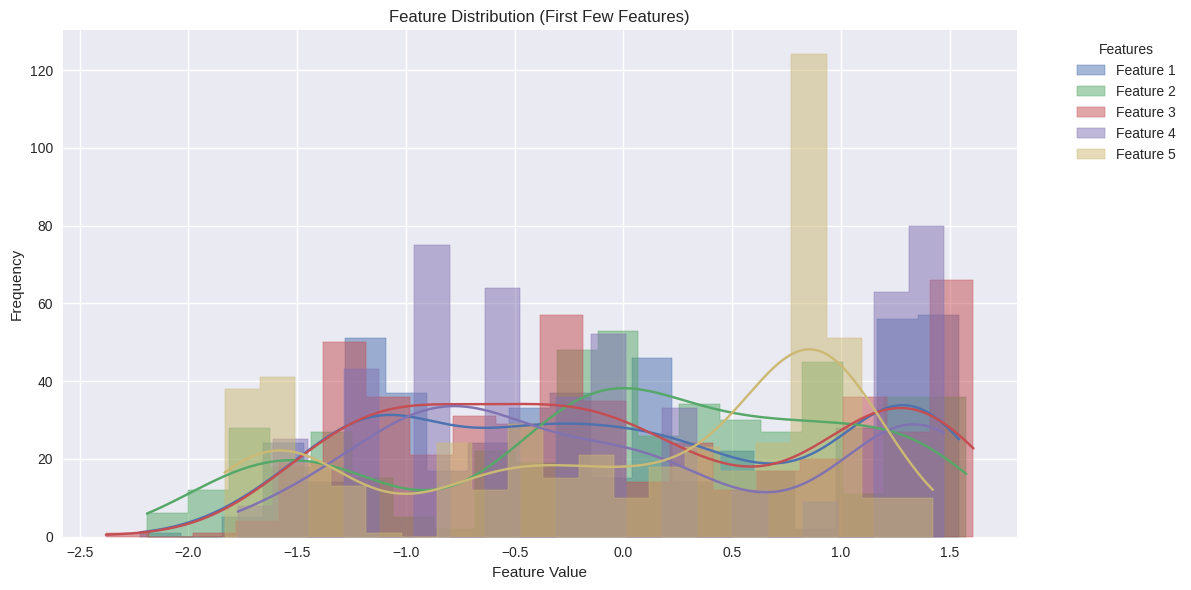

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Instantiate the feature extractor
extractor = FruitFeatureExtractor(target_size=(224, 224))

# Load a small dataset of images (modify the path as needed)
image_paths = list(Path(zenodo_fruitQ_DB_dataset_path).rglob("*.[jp][pn][g]"))[:500]  # Limit to 500 images for performance

# Extract features
print("Extracting features from images...")
features_considerated = ['color', 'space', 'texture']
features = extractor.prepare_dataset(image_paths, features_considerated, fit_scaler=True)

# Visualize feature distributions (histogram)
plt.figure(figsize=(12, 6))
for i in range(5):
    sns.histplot(features[:, i], kde=True, label=f'Feature {i + 1}', bins=20, element="step")
plt.title("Feature Distribution (First Few Features)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Features")
plt.tight_layout()
plt.show()

## Model Evaluator Logic

In [63]:
class ModelEvaluator:
    def __init__(self, quality_labels=['Fresh', 'Mild', 'Rotten']):
        self.quality_labels = quality_labels
    
    def evaluate_model(self, y_true, y_pred, model_name="Model"):
        """Evaluate model performance with metrics and visualization"""
        print(f"\n{model_name} Performance:")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.quality_labels))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.quality_labels,
                   yticklabels=self.quality_labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Test Classification with Baseline Models

In [64]:
class RandomClassifier(BaseEstimator, ClassifierMixin):
    """Classifier that predicts randomly based on training class distribution"""
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.class_probs_ = np.bincount(y) / len(y)
        return self
        
    def predict(self, X):
        return np.random.choice(self.classes_, size=len(X), p=self.class_probs_)

class MajorityClassifier(BaseEstimator, ClassifierMixin):
    """Classifier that always predicts the most common class from training"""
    def fit(self, X, y):
        self.majority_class_ = np.bincount(y).argmax()
        return self
        
    def predict(self, X):
        return np.full(len(X), self.majority_class_)

In [65]:
def run_baseline_tests(train_paths, train_labels, test_paths, test_labels):
    # 1. Try random classifier
    print("\nRandom Classifier (based on class distribution):")
    rand_clf = RandomClassifier()
    rand_clf.fit(None, train_labels)
    rand_pred = rand_clf.predict(test_labels)
    print(classification_report(test_labels, rand_pred))
    
    # 2. Try majority classifier
    print("\nMajority Classifier:")
    maj_clf = MajorityClassifier()
    maj_clf.fit(None, train_labels)
    maj_pred = maj_clf.predict(test_labels)
    print(classification_report(test_labels, maj_pred))

In [66]:
loader = FruitQualityDataLoader()
image_paths, labels = loader.load_zenodo_dataset('fruit_datasets/zenodo_data', subset="FruQ-DB")
print(len(image_paths))

# Split data
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Run baseline tests
run_baseline_tests(train_paths, train_labels, test_paths, test_labels)

Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images
5647

Random Classifier (based on class distribution):
              precision    recall  f1-score   support

           0       0.40      0.39      0.40       437
           1       0.25      0.27      0.26       273
           2       0.40      0.39      0.39       420

    accuracy                           0.36      1130
   macro avg       0.35      0.35      0.35      1130
weighted avg       0.36      0.36      0.36      1130


Majority Classifier:
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       437
           1       0.00      0.00      0.00       273
           2       0.00      0.00      0.00       420

    accuracy                           0.39      1130
   macro avg       0.13      0.33      0.19      1130
weighted avg       0.15      0.39      0.22      1130



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Check to see if there is data leakage

In [67]:
def check_path_overlap(train_paths, test_paths):
   train_set = set(train_paths)
   test_set = set(test_paths)
   
   overlap = train_set.intersection(test_set)
   
   if overlap:
       print(f"Found {len(overlap)} overlapping paths")
       print("Sample overlaps:")
       for path in list(overlap)[:5]:
           print(path)
       return True
   else:
       print("No overlapping paths found")
       return False
   
has_overlap = check_path_overlap(train_paths, test_paths)

No overlapping paths found


## Classification : extracting features

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


# Define paths to Zenodo (training) and Kaggle (testing) datasets
zenodo_path = "fruit_datasets/zenodo_data"
kaggle_path = "fruit_datasets/kaggle_data"

# Initialize the dataset loader
data_loader = FruitQualityDataLoader()

# Load datasets
print("\nLoading Zenodo dataset for training...")
zenodo_paths, zenodo_labels = data_loader.load_zenodo_dataset(zenodo_path, subset="FruQ-DB")

print("\nLoading Kaggle dataset for testing...")
kaggle_paths, kaggle_labels = data_loader.load_kaggle_dataset(kaggle_path)

# Sample a subset of the datasets for faster testing
sample_percentage = 100
print(f"\nSampling {sample_percentage}% of the Zenodo dataset for training...")
zenodo_paths, zenodo_labels = data_loader.sample_dataset(zenodo_paths, zenodo_labels, percentage=sample_percentage, seed=42)

sample_percentage = 20
print(f"\nSampling {sample_percentage}% of the Kaggle dataset for testing...")
kaggle_paths, kaggle_labels = data_loader.sample_dataset(kaggle_paths, kaggle_labels, percentage=sample_percentage, seed=42)

# Specify features to consider
features_considerated = ['color', 'texture', 'spatial']

# Extract features from Zenodo (training set) and Kaggle (testing set)
print("\nExtracting features from Zenodo...")
feature_extractor = FruitFeatureExtractor(target_size=(224, 224))
zenodo_features = np.array([
    feature_extractor.extract_selected_features(path, features_considerated) for path in zenodo_paths
])

print("\nExtracting features from Kaggle...")
kaggle_features = np.array([
    feature_extractor.extract_selected_features(path, features_considerated) for path in kaggle_paths
])


# Scale features
scaler = StandardScaler()
zenodo_features_scaled = scaler.fit_transform(zenodo_features)
kaggle_features_scaled = scaler.fit_transform(kaggle_features)



Loading Zenodo dataset for training...
Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images

Loading Kaggle dataset for testing...

Processing Bad Quality_Fruits...
Processing Apple_Bad...
Processing Banana_Bad...
Processing Guava_Bad...
Processing Lime_Bad...
Processing Orange_Bad...
Processing Pomegranate_Bad...

Processing Good Quality_Fruits...
Processing Apple_Good...
Processing Banana_Good...
Processing Guava_Good...
Processing Lime_Good...
Processing Orange_Good...
Processing Pomegranate_Good...

Processing Mixed Qualit_Fruits...
Processing Apple...
Processing Banana...
Processing Guava...
Processing Lemon...
Processing Orange...
Processing Pomegranate...

Dataset Statistics:
Good/Fresh: 9170 images
Mild/Mixed: 1074 images
Rotten/Bad: 5575 images

Sampling 100% of the Zenodo dataset for training...
Sampled 5647/5647 (100%) images.

Sampling 20% of the Kaggle dataset for testing..

## Custom KNN on Zenodo and on Kaggle 

In [69]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

class CustomKNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """Store training data."""
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """Predict the labels for test data."""
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

    def _predict_single(self, x):
        """Predict the label for a single test point."""
        # Compute Euclidean distances
        distances = np.linalg.norm(self.X_train - x, axis=1)
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Get the labels of the k nearest neighbors
        k_nearest_labels = self.y_train[k_indices]
        # Perform majority voting
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

def evaluate_knn(X, y, k=5, test_size=0.2, dataset_name="Dataset"):
    """Train and test the CustomKNN on a dataset with a train-test split."""
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    # Print dataset split details
    print(f"\nUsing {dataset_name} with an {100 * (1 - test_size):.0f}% train / {100 * test_size:.0f}% test split:")
    print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")
    
    # Initialize and train the KNN classifier
    knn = CustomKNN(k=k)
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Print classification report
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_test, y_pred, target_names=data_loader.quality_labels))

# Load and scale datasets
print("\nScaling and splitting Kaggle dataset...")
kaggle_features_scaled, kaggle_labels = scaler.fit_transform(kaggle_features), np.array(kaggle_labels)

print("\nScaling and splitting Zenodo dataset...")
zenodo_features_scaled, zenodo_labels = scaler.fit_transform(zenodo_features), np.array(zenodo_labels)

# Evaluate the KNN on Kaggle dataset
evaluate_knn(kaggle_features_scaled, kaggle_labels, k=5, test_size=0.2, dataset_name="Kaggle Dataset")

# Evaluate the KNN on Zenodo dataset
evaluate_knn(zenodo_features_scaled, zenodo_labels, k=5, test_size=0.2, dataset_name="Zenodo Dataset")

# Combine Zenodo and Kaggle datasets
print("\nCombining Zenodo and Kaggle datasets for cross-dataset testing...")
combined_features = np.vstack([zenodo_features_scaled, kaggle_features_scaled])
combined_labels = np.hstack([zenodo_labels, kaggle_labels])

# Print dataset combination details
print(f"Combined dataset size: {len(combined_labels)} samples.")
print(f"Zenodo samples: {len(zenodo_labels)}, Kaggle samples: {len(kaggle_labels)}")

# Evaluate the KNN on the combined dataset
evaluate_knn(combined_features, combined_labels, k=5, test_size=0.2, dataset_name="Combined Dataset")



Scaling and splitting Kaggle dataset...

Scaling and splitting Zenodo dataset...

Using Kaggle Dataset with an 80% train / 20% test split:
Training samples: 2530, Testing samples: 633

Classification Report for Kaggle Dataset:
              precision    recall  f1-score   support

  Good/Fresh       0.95      0.95      0.95       374
  Mild/Mixed       0.80      0.88      0.83        40
  Rotten/Bad       0.94      0.92      0.93       219

    accuracy                           0.94       633
   macro avg       0.89      0.92      0.90       633
weighted avg       0.94      0.94      0.94       633


Using Zenodo Dataset with an 80% train / 20% test split:
Training samples: 4517, Testing samples: 1130

Classification Report for Zenodo Dataset:
              precision    recall  f1-score   support

  Good/Fresh       1.00      1.00      1.00       437
  Mild/Mixed       1.00      1.00      1.00       273
  Rotten/Bad       1.00      1.00      1.00       420

    accuracy              

### test KNN on homde made pictures 

In [70]:
def test_personal_photos(photo_paths, feature_extractor, knn_model):
    """
    Test personal photos using the trained KNN model.
    """
    print("\nTesting on personal photos...")

    # Extract features for personal photos
    personal_features = np.array([
        feature_extractor.extract_selected_features(photo, ['color', 'texture', 'spatial'])
        for photo in photo_paths
    ])

    # Scale personal photo features using the scaler fitted earlier
    personal_features_scaled = scaler.transform(personal_features)

    # Predict labels for personal photos
    predictions = knn_model.predict(personal_features_scaled)

    # Display predictions for each photo
    for photo, prediction in zip(photo_paths, predictions):
        label = data_loader.quality_labels[prediction]
        print(f"Photo: {photo}, Predicted Label: {label}")

    # display photos with predictions
    import matplotlib.pyplot as plt
    for photo, prediction in zip(photo_paths, predictions):
        img = cv2.imread(photo)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Prediction: {data_loader.quality_labels[prediction]}")
        plt.axis("off")
        plt.show()

# Example usage for personal photos
personal_photo_paths = [
    "self_made_pictures/IMG_6571.jpg",
    "self_made_pictures/IMG_6573.jpg",
    "self_made_pictures/IMG_6574.jpg"
]

# Train the KNN model on the combined dataset
final_knn = CustomKNN(k=5)
final_knn.fit(combined_features, combined_labels)

# Test on personal photos
#test_personal_photos(personal_photo_paths, feature_extractor, final_knn)

## ML Models creation

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import numpy as np

# Define the neural network model
def create_nn(input_dim, output_dim):
    """
    Create an enhanced neural network with additional layers and optimizations.
    
    Parameters:
    -----------
    input_dim : int
        The number of input features.
    output_dim : int
        The number of output classes.
    
    Returns:
    --------
    model : Sequential
        A compiled Keras model.
    """
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),  # Normalize activations
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(output_dim, activation='softmax')  # Softmax for multi-class classification
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for stability
        loss='sparse_categorical_crossentropy',  # Suitable for integer labels
        metrics=['accuracy']
    )
    return model

# Create the neural network
input_dim = zenodo_features_scaled.shape[1]  # Number of input features
output_dim = len(np.unique(zenodo_labels))  # Number of output classes
model = create_nn(input_dim, output_dim)


/home/jeff/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Preprocessing, train, test


Training and testing with Train on Zenodo, Test on Zenodo configuration...
Class weights: {0: 0.8626642224259089, 1: 1.3800097751710656, 2: 0.8959225765508488}
Training the neural network...
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5937 - loss: 0.9620 - val_accuracy: 0.9115 - val_loss: 0.3467 - learning_rate: 5.0000e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8606 - loss: 0.3630 - val_accuracy: 0.9646 - val_loss: 0.1507 - learning_rate: 5.0000e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9054 - loss: 0.2589 - val_accuracy: 0.9770 - val_loss: 0.0895 - learning_rate: 5.0000e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9244 - loss: 0.1915 - val_accuracy: 0.9814 - val_loss: 0.0644 - learning_rate: 5.0000e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.1735 - val_accuracy: 0.9743 - val_loss: 0.0549 - learning_rate: 5.0000e-04
Epoch 6/50
142/142 ━━━━━━━━

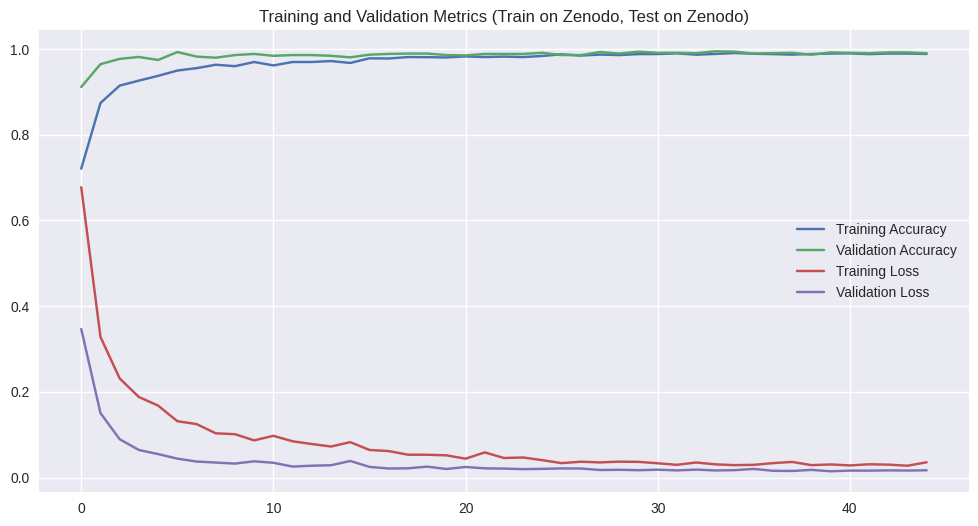


Evaluating on the test set...
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report for Train on Zenodo, Test on Zenodo:
              precision    recall  f1-score   support

  Good/Fresh       0.99      1.00      1.00      2182
  Mild/Mixed       0.99      0.99      0.99      1364
  Rotten/Bad       1.00      1.00      1.00      2101

    accuracy                           1.00      5647
   macro avg       1.00      1.00      1.00      5647
weighted avg       1.00      1.00      1.00      5647


Training and testing with Train on Zenodo, Test on Kaggle configuration...
Class weights: {0: 0.8626642224259089, 1: 1.3800097751710656, 2: 0.8959225765508488}
Training the neural network...
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0319 - val_accuracy: 0.9929 - val_loss: 0.0151 - learning_rate: 3.1250e-05
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0302 - val_accuracy: 0.9929 - val_loss: 0.0151 - learning_

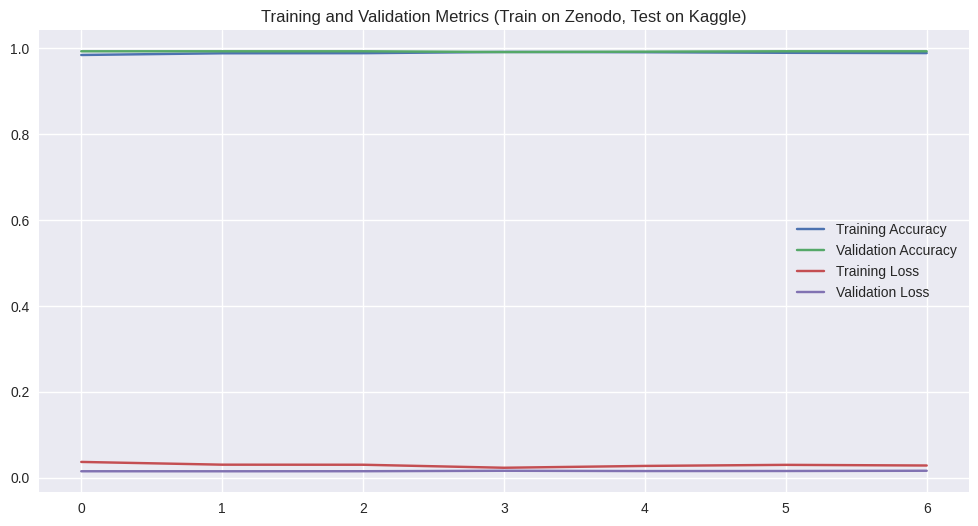


Evaluating on the test set...
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report for Train on Zenodo, Test on Kaggle:
              precision    recall  f1-score   support

  Good/Fresh       0.55      0.44      0.49      1869
  Mild/Mixed       0.05      0.08      0.06       200
  Rotten/Bad       0.38      0.47      0.42      1094

    accuracy                           0.43      3163
   macro avg       0.33      0.33      0.32      3163
weighted avg       0.46      0.43      0.44      3163


Training and testing with Train on Kaggle, Test on Kaggle configuration...
Class weights: {0: 0.5641162832174068, 1: 5.2716666666666665, 2: 0.9637416209628276}
Training the neural network...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3670 - loss: 4.9268 - val_accuracy: 0.4218 - val_loss: 4.8393 - learning_rate: 7.8125e-06
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4143 - loss: 3.9657 - val_accuracy: 0.4534 - val_loss: 4.0977 - learning_rate:

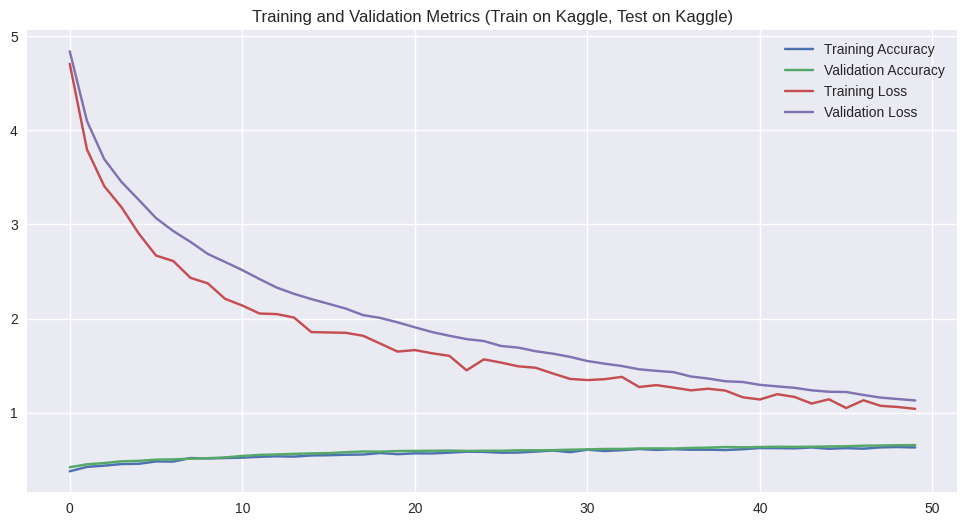


Evaluating on the test set...
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step

Classification Report for Train on Kaggle, Test on Kaggle:
              precision    recall  f1-score   support

  Good/Fresh       0.91      0.55      0.68      1869
  Mild/Mixed       0.23      0.89      0.37       200
  Rotten/Bad       0.73      0.84      0.78      1094

    accuracy                           0.67      3163
   macro avg       0.62      0.76      0.61      3163
weighted avg       0.80      0.67      0.70      3163


Training and testing with Train on Kaggle, Test on Zenodo configuration...
Class weights: {0: 0.5641162832174068, 1: 5.2716666666666665, 2: 0.9637416209628276}
Training the neural network...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 0.9874 - val_accuracy: 0.6572 - val_loss: 1.1192 - learning_rate: 7.8125e-06
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.9771 - val_accuracy: 0.6588 - val_loss: 1.0915 - learning_rate

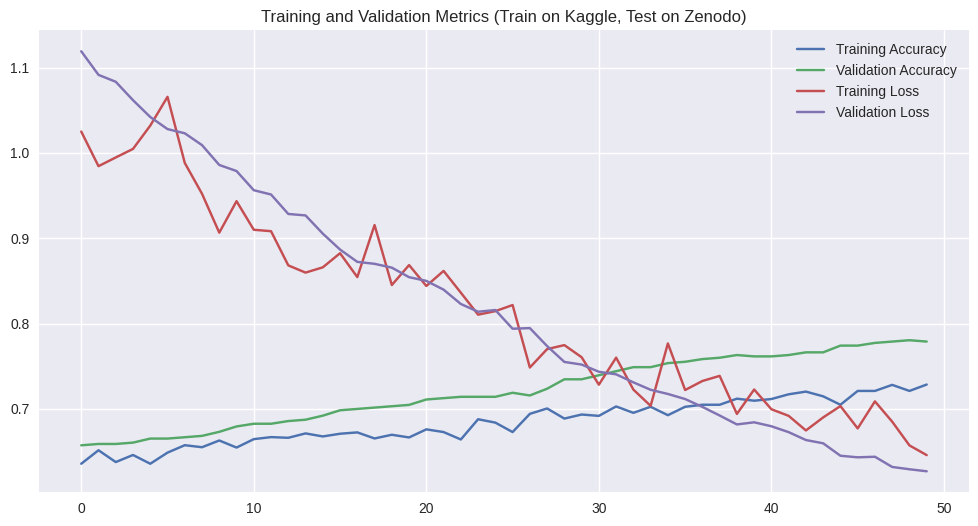


Evaluating on the test set...
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report for Train on Kaggle, Test on Zenodo:
              precision    recall  f1-score   support

  Good/Fresh       0.91      0.66      0.76      2182
  Mild/Mixed       0.72      0.96      0.83      1364
  Rotten/Bad       0.81      0.86      0.83      2101

    accuracy                           0.81      5647
   macro avg       0.81      0.83      0.81      5647
weighted avg       0.83      0.81      0.80      5647



In [72]:
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_and_evaluate_model(X_train, y_train, X_test, y_test, dataset_description):
    """
    Train and evaluate the neural network on a given train-test split.
    """
    print(f"\nTraining and testing with {dataset_description} configuration...")
    
    # Compute class weights to handle imbalance
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))
    print(f"Class weights: {class_weights}")

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6
    )

    # Train the model
    print("Training the neural network...")
    history = model.fit(
        X_train, 
        y_train, 
        epochs=50, 
        batch_size=32, 
        validation_split=0.2, 
        class_weight=class_weights, 
        callbacks=[early_stopping, reduce_lr], 
        verbose=1
    )

    # Visualize training metrics
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"Training and Validation Metrics ({dataset_description})")
    plt.show()

    # Evaluate on the test set
    print("\nEvaluating on the test set...")
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)

    # Classification report
    print(f"\nClassification Report for {dataset_description}:")
    print(classification_report(y_test, predicted_labels, target_names=data_loader.quality_labels))

# Preprocess Zenodo and Kaggle datasets
zenodo_features_scaled = scaler.fit_transform(zenodo_features)
zenodo_labels = np.array(zenodo_labels)

kaggle_features_scaled = scaler.fit_transform(kaggle_features)
kaggle_labels = np.array(kaggle_labels)

# Four configurations
# 1. Train on Zenodo, Test on Zenodo
train_and_evaluate_model(
    zenodo_features_scaled, 
    zenodo_labels, 
    zenodo_features_scaled, 
    zenodo_labels, 
    "Train on Zenodo, Test on Zenodo"
)

# 2. Train on Zenodo, Test on Kaggle
train_and_evaluate_model(
    zenodo_features_scaled, 
    zenodo_labels, 
    kaggle_features_scaled, 
    kaggle_labels, 
    "Train on Zenodo, Test on Kaggle"
)

# 3. Train on Kaggle, Test on Kaggle
train_and_evaluate_model(
    kaggle_features_scaled, 
    kaggle_labels, 
    kaggle_features_scaled, 
    kaggle_labels, 
    "Train on Kaggle, Test on Kaggle"
)

# 4. Train on Kaggle, Test on Zenodo
train_and_evaluate_model(
    kaggle_features_scaled, 
    kaggle_labels, 
    zenodo_features_scaled, 
    zenodo_labels, 
    "Train on Kaggle, Test on Zenodo"
)


Observations : we can obtain very good performances (between 90 and 100% accuracy) when we split test and train on the same dataset. On the other hand, the quality of the results decreases when we train on a dataset and test on another fundamentally different one (different angle, light, fruits, etc.). It is very interesting to observe that even in this case, with kaggle train and zenodo test, we obtain 85% accuracy which is quite remarkable for an agnostic recognizer

# Regression 

Classification is good, but here we would like a continuous measurement of the fruit/vegetable quality. For this we use the aspect ordered of the dataset fruiQ-multi : supervised regression to predict fruit quality on a continuous scale [0, 1].
Floating-point labels are generated based on the order of images within the Good, Mild, and Rotten folders to capture a gradual progression of quality : good [0, 1/3]; mild [1/3, 2/3]; rotten [2/3, 1]

## Regressor with random forest & neural network 

In [85]:
import os
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


class FruQMultiRegressor:
    def __init__(self, target_size=(224, 224), model_type="random_forest", rf_params=None, nn_params=None):
        self.feature_extractor = FruitFeatureExtractor(target_size=target_size)
        self.model_type = model_type

        if model_type == "random_forest":
            self.model = RandomForestRegressor(
                n_estimators=rf_params.get("n_estimators", 100),
                max_depth=rf_params.get("max_depth", None),
                min_samples_split=rf_params.get("min_samples_split", 2),
                min_samples_leaf=rf_params.get("min_samples_leaf", 1),
                n_jobs=-1
            )
        elif model_type == "neural_network":
            self.model = self._build_nn_model(
                input_dim=nn_params.get("input_dim"),
                nn_params=nn_params
            )
        else:
            raise ValueError("Invalid model type. Choose 'random_forest' or 'neural_network'.")

    def _build_nn_model(self, input_dim, nn_params):
        model = Sequential([
            Dense(nn_params.get("hidden_units_1", 128), activation="relu", input_dim=input_dim),
            Dropout(nn_params.get("dropout_1", 0.3)),
            Dense(nn_params.get("hidden_units_2", 64), activation="relu"),
            Dropout(nn_params.get("dropout_2", 0.3)),
            Dense(1, activation="linear")
        ])
        model.compile(
            optimizer=Adam(learning_rate=nn_params.get("learning_rate", 0.001)),
            loss="mean_squared_error"
        )
        return model

    def assign_labels(self, base_dir, sample_fraction=1.0):
        base_dir = Path(base_dir)
        image_paths = []
        labels = []

        for fruit_folder in base_dir.iterdir():
            if not fruit_folder.is_dir():
                continue

            print(f"Processing fruit: {fruit_folder.name}")

            good_dir = fruit_folder / "Good"
            mild_dir = fruit_folder / "Mild"
            rotten_dir = fruit_folder / "Rotten"

            for quality_dir, start, end in [
                (good_dir, 0.0, 1 / 3),
                (mild_dir, 1 / 3, 2 / 3),
                (rotten_dir, 2 / 3, 1.0)
            ]:
                if quality_dir.exists():
                    quality_images = sorted(quality_dir.glob("*.[jp][pn][g]"))
                    n_images = int(len(quality_images) * sample_fraction)
                    quality_images = quality_images[:n_images]

                    for idx, img_path in enumerate(quality_images):
                        score = start + (idx / max(1, (n_images - 1))) * (end - start)
                        image_paths.append(str(img_path))
                        labels.append(score)

        return image_paths, np.array(labels)

    def train(self, train_paths, train_labels, nn_epochs=20, nn_batch_size=32):
        print("Extracting features for training...")
        features = self.feature_extractor.prepare_dataset(train_paths, features_considerated, fit_scaler=True)

        if self.model_type == "random_forest":
            print("Training Random Forest model...")
            self.model.fit(features, train_labels)
        elif self.model_type == "neural_network":
            print("Training Neural Network model...")
            class_weights = class_weight.compute_class_weight(
                'balanced', classes=np.unique(train_labels), y=train_labels
            )
            class_weights = dict(enumerate(class_weights))
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
            self.model.fit(
                features, train_labels,
                epochs=nn_epochs,
                batch_size=nn_batch_size,
                validation_split=0.2,
                class_weight=class_weights,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )

    def predict(self, test_paths):
        if isinstance(test_paths, str):
            test_paths = [test_paths]

        print("Extracting features for prediction...")
        features = self.feature_extractor.prepare_dataset(test_paths, features_considerated, fit_scaler=False)

        print("Predicting quality scores...")
        predictions = self.model.predict(features)
        return np.clip(predictions, 0, 1)


def evaluate_model(regressor, test_paths, test_labels, model_name):
    print(f"\nEvaluating {model_name} model...")
    predicted_scores = regressor.predict(test_paths)
    mae = mean_absolute_error(test_labels, predicted_scores)
    r2 = r2_score(test_labels, predicted_scores)
    print(f"{model_name} - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"{model_name} - R2 Score: {r2:.4f}")
    print("\nSample predictions:")
    for img, pred, true in zip(test_paths[:10], predicted_scores[:10], test_labels[:10]):
        pred_value = pred.item() if hasattr(pred, 'item') else pred
        true_value = true.item() if hasattr(true, 'item') else true
        print(f"Image: {img}, Predicted Score: {pred_value:.4f}, True Score: {true_value:.4f}")


def setup_and_train(train_path, test_path, sample_fraction=0.1):
    print(f"Setting up training and testing for Train: {train_path}, Test: {test_path}...")
    regressor_rf = FruQMultiRegressor(model_type="random_forest", rf_params={"n_estimators": 100, "max_depth": 10})
    regressor_nn = FruQMultiRegressor(model_type="neural_network", nn_params={"input_dim": 72, "learning_rate": 0.001})

    # Assign labels with sampling
    train_paths, train_labels = regressor_rf.assign_labels(train_path, sample_fraction)
    test_paths, test_labels = regressor_rf.assign_labels(test_path, sample_fraction)
    print('train_paths', train_paths, 'train_labels', train_labels)
    # Train and return
    print("\nTraining Random Forest...")
    regressor_rf.train(train_paths, train_labels)

    print("\nTraining Neural Network...")
    regressor_nn.train(train_paths, train_labels, nn_epochs=40)

    return train_paths, test_paths, train_labels, test_labels, regressor_rf, regressor_nn





In [86]:
zenodo_path = "fruit_datasets/zenodo_data/FruQ-multi"
kaggle_path = "fruit_datasets/kaggle_data/"

print("\nConfig 1: Train and Test on Zenodo")
train_paths, test_paths, train_labels, test_labels, regressor_rf, regressor_nn = setup_and_train(
    zenodo_path, zenodo_path, sample_fraction=0.01
)
evaluate_model(regressor_rf, test_paths, test_labels, "Random Forest (Zenodo)")
evaluate_model(regressor_nn, test_paths, test_labels, "Neural Network (Zenodo)")

# print("\nConfig 2: Train and Test on Kaggle")
# train_paths, test_paths, train_labels, test_labels, regressor_rf, regressor_nn = setup_and_train(
#     kaggle_path, kaggle_path, sample_fraction=0.01,"kaggle","kaggle"
# )
# evaluate_model(regressor_rf, test_paths, test_labels, "Random Forest (Kaggle)")
# evaluate_model(regressor_nn, test_paths, test_labels, "Neural Network (Kaggle)")

# print("\nConfig 3: Train on Zenodo, Test on Kaggle")
# train_paths, test_paths, train_labels, test_labels, regressor_rf, regressor_nn = setup_and_train(
#     zenodo_path, kaggle_path, sample_fraction=0.01,"zenodo","kaggle"
# )
# evaluate_model(regressor_rf, test_paths, test_labels, "Random Forest (Zenodo->Kaggle)")
# evaluate_model(regressor_nn, test_paths, test_labels, "Neural Network (Zenodo->Kaggle)")

# print("\nConfig 4: Train on Kaggle, Test on Zenodo")
# train_paths, test_paths, train_labels, test_labels, regressor_rf, regressor_nn = setup_and_train(
#     kaggle_path, zenodo_path, sample_fraction=0.01,"kaggle","zenodo"
# )
evaluate_model(regressor_rf, test_paths, test_labels, "Random Forest (Kaggle->Zenodo)")
evaluate_model(regressor_nn, test_paths, test_labels, "Neural Network (Kaggle->Zenodo)")


Config 1: Train and Test on Zenodo
Setting up training and testing for Train: fruit_datasets/zenodo_data/FruQ-multi, Test: fruit_datasets/zenodo_data/FruQ-multi...
Processing fruit: BananaDB
Processing fruit: CucumberQ
Processing fruit: GrapeQ
Processing fruit: KakiQ
Processing fruit: PapayaQ
Processing fruit: PeachQ
Processing fruit: PearQ
Processing fruit: PepperQ
Processing fruit: StrawberryQ
Processing fruit: tomatoQ
Processing fruit: WatermeloQ
Processing fruit: BananaDB
Processing fruit: CucumberQ
Processing fruit: GrapeQ
Processing fruit: KakiQ
Processing fruit: PapayaQ
Processing fruit: PeachQ
Processing fruit: PearQ
Processing fruit: PepperQ
Processing fruit: StrawberryQ
Processing fruit: tomatoQ
Processing fruit: WatermeloQ
train_paths ['fruit_datasets/zenodo_data/FruQ-multi/BananaDB/Good/Image1.png', 'fruit_datasets/zenodo_data/FruQ-multi/BananaDB/Rotten/Image1001.png', 'fruit_datasets/zenodo_data/FruQ-multi/BananaDB/Rotten/Image1003.png', 'fruit_datasets/zenodo_data/FruQ-m

/home/jeff/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Feature extraction completed!
Training Random Forest model...

Training Neural Network...
Extracting features for training...
Processing image 0/77
Feature extraction completed!
Training Neural Network model...
Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 1.6066 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8891 - val_loss: 0.3023 - learning_rate: 0.0010
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7521 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6168 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7039 - val_loss: 0.1415 - learning_rate: 0.0010
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4282 - val_loss: 0.1359 - learning_rate: 0.0010
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4013 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29

## Personnal pictures test


Predicting quality scores for test images...
Extracting features for prediction...
Processing image 0/3
Feature extraction completed!
Predicting quality scores...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Displaying Predictions:


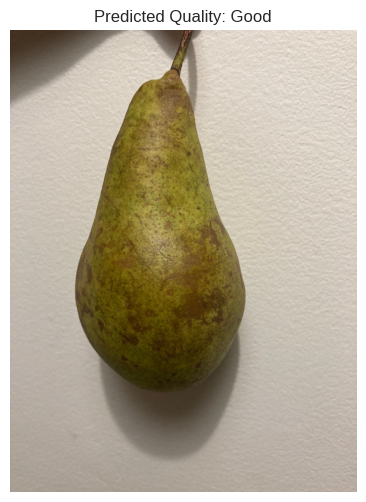

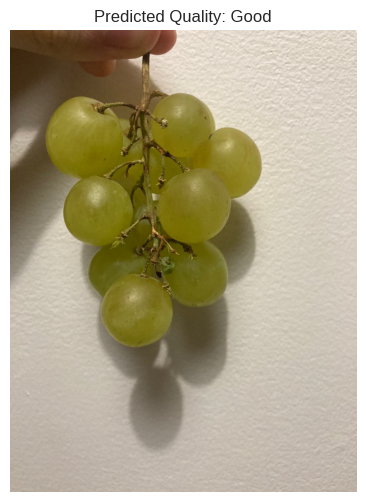

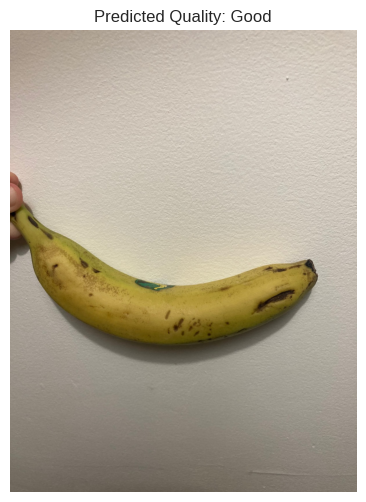

In [88]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define the paths to your images
test_image_paths = [
    "fruit_datasets/self_made_pictures/IMG_6574.jpg",
    "fruit_datasets/self_made_pictures/IMG_6573.jpg",
    "fruit_datasets/self_made_pictures/IMG_6571.jpg"
]

# Predict quality scores using the regressor

print("\nPredicting quality scores for test images...")
predicted_scores = regressor_nn.predict(test_image_paths)

# Display predictions with images
print("\nDisplaying Predictions:")
for img_path, score in zip(test_image_paths, predicted_scores):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    # Determine the quality category based on the predicted score
    if score < 1/3:
        quality = "Rotten"
    elif score < 2/3:
        quality = "Mild"
    else:
        quality = "Good"

    # Display the image with the predicted score and category
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Quality: {quality}")
    plt.show()
